# Forever Monsterous:  A Kung Faux Pandas Tutorial

Kung Faux Pandas (KFP) is a set of tools which extends the [Pandas](https://pandas.pydata.org/ "Pandas Homepage") dataframe to include some tools for generating synthetic data.

There are many reasons to create synthetic data, but KFP assumes the reason is to give a statistical analyst "realistic" data, which we term _faux_ data, without exposing the real dataset.   
Details on the tools and how to install them are available on the [KFP github repository] (https://github.com/CUD2V/kungfauxpandas).

This tutorial assumes you have installed KFP as well as some standard data science tools, such as numpy, scipy, and matplotlib.

## Chapter 1:  The Problem

Monsters are a tricky lot.   They have widely varying statistics and capabilities and many have spent centuries building up their reputations in order to disuade adventurers from invading their spaces.  The smarter varieties of monsters have retained good lawyers through the ages, and it in most jurisdictions it's actually illegal to publish the "personal" data on any monster.

Of course, we would like to study the monsters without violating their privacy rights.   KFP can help this problem!

1. Generate a fake data set based on the real stuff
2. Work out all steps necessary to clean the data up
3. Code the data cleaning steps into a function
4. Re-run the data generation using the data cleaner
5. Get a clean, synthetic data set to study
6. Have a trusted agent (DM?) run your study code on the real data and deliver you the results.



In [1]:
import sqlite3
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import pylab as plt
from collections import Counter
import datetime
import sys
sys.path.append('../')
sys.path.append('../../../plugins/DataSynthesizer/DataSynthesizer/')
sys.path.append('../../../plugins/DataSynthesizer/')
from importlib import reload
from kungfauxpandas import KungFauxPandas, TrivialPlugin, DataSynthesizerPlugin, KDEPlugin
from fractions import Fraction
%matplotlib inline

# Step 0:  Get the real data
This scenario models one in which the monsters' private data is unavailable to us as researchers.  We assume there would be a trusted intermediary who could hold the real data and run the processing for us.





In [2]:
# Data from: https://docs.google.com/spreadsheets/d/1FIjaz6S0JXrXaCVhHEDeq-nH7xHzlqAx6inuRbDjhjU/edit#gid=1346812326
# Other fun data: https://docs.google.com/spreadsheets/d/16ajgJpvUI0wYcSU7kjHutw8oB6Zv6eIAo5JtI6PLvu8/edit#gid=776794522
monsterfile = "../../../data/D&D 5e Monster List with Ability Scores.xlsx - Monsters by Ability Score.csv"
df = pd.read_csv(monsterfile)
df.sample(10)

,Name,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
297,Bargheist,Fiend,NE,Large,4,17,90,19,15,14,13,12,14.0
54,Giant Elk,Beast,U,Huge,2,14,42,19,16,14,7,14,10.0
581,Cave Fisher,Monstrosity,U,Medium,3,16,58,16,13,14,3,10,3.0
30,Nothic,Aberration,NE,Medium,2,15,45,14,16,16,13,10,8.0
145,Empyrean,Celestial,CG OR NE,Huge,23,22,313,30,21,30,21,22,27.0
524,Kenku,Humanoid,CN,Medium,1/4,13,13,10,16,10,11,10,10.0
519,Acolyte,Humanoid,ANY,Medium,1/4,10,9,10,10,10,10,14,11.0
602,Merrow,Monstrosity,CE,Large,2,13,45,18,10,15,8,10,9.0
27,Berbalang,Aberration,NE,Medium,2,14,38,9,16,9,17,11,10.0
52,Giant Boar,Beast,U,Large,2,12,42,17,10,16,2,7,5.0


## Step 1: Grab round 1 of the fake data

In [3]:
# Instantiate KFP object
kfpd = KungFauxPandas(plugin=KDEPlugin(),
                      logging='../../../data/kfp_log.db',
                      db_file='../../../data/monsters.db')

# Ensure KFP object has the options we want
kfpd.plugin.capture_covariance = True  # models how the stats interact with each other
kfpd.plugin.determine_factors =  True  # make a judgement about whether a measure is numeric or categorical

# Generate the Fake data
kfpd.plugin.fauxify(df_in=df)

# Do some renames to improve readability
faux_df = kfpd.plugin.df_out
factor_indices = kfpd.plugin.factor_indices


Preprocess None
Building KDE Model



Now we have fake data! It still needs some work, though.

# Step 2: EDA and Data Cleanup

In [4]:
faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
443,15.899096,4.057081,3.012643,14.941855,12.973115,8.831121,7.056146,13.950936,12.998288,5.940831,10.975571,6.925135
26,12.987592,0.057472,3.005373,10.971504,13.038005,36.183037,9.043111,13.969822,12.040305,10.955493,4.971292,13.919917
650,4.912578,3.988626,-0.007954,7.987126,13.978606,103.797753,15.934194,19.014346,13.971177,10.011238,15.026137,11.022766
129,15.001582,1.030263,0.019159,8.995394,14.010009,75.109578,8.035688,18.967817,16.039765,19.028384,12.002626,15.044296
547,10.929021,-0.021200,1.019709,7.061939,15.053572,95.295970,18.151859,12.968780,20.069679,7.033584,9.003956,7.045264


Since we seleccted the KDE plugin, this data was generated with a Gaussian Kernel Density Estimator, which assumes that the samples come from a continuous distribution.   That is, numbers like Hit Points (HP) are assumed to take any decimal value.    Due to our domain expertise, however, we know that these numbers really should all be integers.    One could generate a more complex simulation model or just round off our fake data.   

In [5]:
# Get numbers back to integers
faux_df = faux_df.round().astype('int')
faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
181,14,7,1,10,13,60,18,16,16,5,12,7
686,13,14,0,9,18,64,16,13,14,10,11,10
531,1,7,0,15,13,11,12,16,13,3,12,4
374,4,0,5,26,19,255,27,10,25,16,13,21
252,13,14,0,9,10,75,12,10,16,10,15,14


These look more like we might expect, however some of our fields were factors (i.e. text fields).  We'd like to restore these to their original labels.

In [6]:
# Back-transform factors to their labels
for factor_name in factor_indices:
    alt = factor_indices[factor_name]
    altlab = np.arange(len(alt))
    lookup = dict(zip(altlab,alt))
    faux_df[factor_name]=[lookup[xx] for xx in faux_df[factor_name]]

faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
273,Fiend (Demon),CE,Medium,4,16,83,19,16,16,11,12,13
87,Humanoid,NE,Medium,20,17,262,12,18,16,17,21,22
304,Humanoid,LE,Medium,8,18,91,16,14,15,14,14,15
529,Construct,LN,Medium,1/2,15,16,12,13,12,9,10,9
56,Humanoid,CE,Small,1/4,13,14,10,14,12,11,5,9


This looks much more like what we'd expect.    Lets do some exploration and cleaning.

In [7]:
distincts = faux_df.Type.unique()
print(distincts)
distincts.sort()
print(distincts)


['Humanoid' 'Monstrosity' 'Fiend (Devil)' 'Aberration' 'Beast' 'Fiend'
 'Dragon' 'Plant' 'Construct' 'Undead' 'Celestial' 'Elemental' 'Fey'
 'Fiend (Demon)' 'Giant' 'Ooze' 'Fiend (demon)']
['Aberration' 'Beast' 'Celestial' 'Construct' 'Dragon' 'Elemental' 'Fey'
 'Fiend' 'Fiend (Demon)' 'Fiend (Devil)' 'Fiend (demon)' 'Giant' 'Humanoid'
 'Monstrosity' 'Ooze' 'Plant' 'Undead']


+ **Boo!  Why is Giant in there twice? A trailing space!**

Lets check the other factors.

In [8]:
distincts = faux_df.Size.unique()
print(distincts)
distincts.sort()
print(distincts)

['Medium' 'Gargantuan' 'Huge' 'Large' 'Small' 'Tiny' 'small' 'large'
 'VARIES']
['Gargantuan' 'Huge' 'Large' 'Medium' 'Small' 'Tiny' 'VARIES' 'large'
 'small']


+ **ooh!  There's "large" and "Large", "small and "Small", and "VARIES" changes capitalization convention.**

In [9]:
distincts = faux_df.ALIGNMENT.unique()
print(distincts)
distincts.sort()
print(distincts)



['LE' 'U' 'NE' 'NG' 'CN' 'N' 'LN' 'LG' 'CE' 'ANY' 'CG' 'E' 'NOT GOOD'
 'CG OR NE' 'NOT LAWFUL' 'ANY EVIL' 'C' 'Same as Eidolon']
['ANY' 'ANY EVIL' 'C' 'CE' 'CG' 'CG OR NE' 'CN' 'E' 'LE' 'LG' 'LN' 'N' 'NE'
 'NG' 'NOT GOOD' 'NOT LAWFUL' 'Same as Eidolon' 'U']


* **No problems jump out here**

In [10]:
distincts = faux_df.CR.unique()
print(distincts)
distincts.sort()
print(distincts)

['2' '15' '22' '13' '4' '1' '5' '14' '1/2' '8' '11' '7' '9' '0' '3' '10'
 '16' '18' '1/8' '1/4' '6' '12' '20' '30' '23' '19' '21' '24' '17' '26' '-']
['-' '0' '1' '1/2' '1/4' '1/8' '10' '11' '12' '13' '14' '15' '16' '17' '18'
 '19' '2' '20' '21' '22' '23' '24' '26' '3' '30' '4' '5' '6' '7' '8' '9']


*  **This has numbers, mostly.  There's a '-' for some reason.   Also, there are fractions which we might want to be numerical.**

Lets build a preprocessor that can fix these problems for us.  

In [11]:
# Preprocessing instructions
def df_preprocess(df):

    # Get rid of rows with missing data
    df=df.dropna()
    
    # Take care of capitalization problems
    df.loc[:,'Size']=[xx.capitalize().strip() for xx in df.Size]
    df.loc[:,'Type']=[xx.capitalize().strip() for xx in df.Type]
    df.loc[:,'ALIGNMENT'] = [xx.upper().strip() for xx in df.ALIGNMENT]
    
    # Convert any '-' values to a 0
    df.loc[:,'CR'] = [float(Fraction(xx)) if xx is not '-' else 0.0 for xx in df.CR]
    return(df)

Lets verify that df_preprocess seems to fix our problems on our original data set.

In [12]:
fixed = df_preprocess(faux_df)
print(fixed.Size.unique(), '\n\n', fixed.Type.unique(),'\n\n',fixed.ALIGNMENT.unique())

print(fixed.CR.unique())

['Medium' 'Gargantuan' 'Huge' 'Large' 'Small' 'Tiny' 'Varies'] 

 ['Humanoid' 'Monstrosity' 'Fiend (devil)' 'Aberration' 'Beast' 'Fiend'
 'Dragon' 'Plant' 'Construct' 'Undead' 'Celestial' 'Elemental' 'Fey'
 'Fiend (demon)' 'Giant' 'Ooze'] 

 ['LE' 'U' 'NE' 'NG' 'CN' 'N' 'LN' 'LG' 'CE' 'ANY' 'CG' 'E' 'NOT GOOD'
 'CG OR NE' 'NOT LAWFUL' 'ANY EVIL' 'C' 'SAME AS EIDOLON']
[  2.     15.     22.     13.      4.      1.      5.     14.      0.5     8.
  11.      7.      9.      0.      3.     10.     16.     18.      0.125
   0.25    6.     12.     20.     30.     23.     19.     21.     24.     17.
  26.   ]


### Generate fake data based on the original _after_ preprocessing.

In [13]:
# Instantiate KFP object
kfpd = KungFauxPandas(plugin=KDEPlugin(),
                      logging='../../../data/kfp_log.db',
                      db_file='../../../data/monsters.db')

# Ensure KFP object has the options we want
kfpd.plugin.capture_covariance = True
kfpd.plugin.determine_factors =  True

# Generate the Fake data
kfpd.plugin.fauxify(df_in=df, preprocess=df_preprocess)

# Do some renames to improve readability
faux_df = kfpd.plugin.df_out
factor_indices = kfpd.plugin.factor_indices

Preprocess <function df_preprocess at 0x1a16150f28>
Building KDE Model


/Users/jamesking/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
# Get numbers back to integers
faux_df = faux_df.round().astype('int')

In [15]:
faux_df.sample(10)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
19,6,3,0,10,19,127,14,16,16,18,11,18
153,1,7,5,7,12,156,23,14,18,7,12,7
174,8,0,1,17,19,310,25,11,25,6,13,14
401,4,6,0,2,17,32,15,14,13,10,11,13
387,11,0,0,3,17,59,16,13,14,10,11,10
641,12,2,0,11,15,247,28,10,20,3,10,9
307,4,1,1,10,18,178,23,10,21,14,11,19
221,12,2,0,15,18,246,28,7,22,1,8,4
145,11,1,3,0,13,13,10,14,12,11,5,9
433,1,7,4,0,11,1,2,11,10,1,8,2


In [16]:
factor_indices

{'ALIGNMENT': Index(['CE', 'LE', 'NE', 'CN', 'N', 'LN', 'LG', 'U', 'CG OR NE', 'CG',
        'SAME AS EIDOLON', 'NG', 'E', 'C', 'ANY', 'NOT GOOD', 'NOT LAWFUL',
        'ANY EVIL'],
       dtype='object'),
 'Size': Index(['Medium', 'Large', 'Gargantuan', 'Small', 'Tiny', 'Huge', 'Varies'], dtype='object'),
 'Type': Index(['Aberration', 'Beast', 'Celestial', 'Construct', 'Dragon', 'Elemental',
        'Fey', 'Fiend', 'Fiend (demon)', 'Fiend (devil)', 'Giant', 'Humanoid',
        'Monstrosity', 'Ooze', 'Plant', 'Undead'],
       dtype='object')}

In [17]:
# Back-transform factors to their labels
for factor_name in factor_indices:
    alt = factor_indices[factor_name]
    altlab = np.arange(len(alt))
    lookup = dict(zip(altlab,alt))
    faux_df[factor_name]=[lookup[xx] for xx in faux_df[factor_name]]



In [18]:
faux_df.sample(5)

,Type,ALIGNMENT,Size,CR,AC,HP,STR,DEX,CON,INT,WIS,CHA
562,Aberration,LE,Medium,4,15,71,6,16,14,16,12,18
202,Humanoid,ANY,Medium,5,16,75,19,15,16,14,13,17
569,Construct,U,Medium,4,20,60,18,13,16,10,10,10
466,Beast,U,Huge,2,13,30,15,13,13,2,10,5
121,Humanoid,NOT GOOD,Medium,0,12,13,11,12,12,10,10,10


**We now have fake data which strongly resembles the real stuff!**

# Comparing the Faux Data to the Original

Any analysis you might be interested in can now be run on the faux data and you can expect the results.

One of the numbers included in the stats is the so-called "Challenge Rating" (CR).  The meaning is detailed [here](https://www.reddit.com/r/DnD/comments/2egr5y/explaining_5e_cr/), but suffice it to say, it's a popular measure of the monster's dangerousness.

One way to test our faux data is to make sure that the generated CR correlates to the generated monsters' stats in the same way that the real CR correlates to the real monsters' stats.  For this, we can use a linear regression.



## Faux Data

In [33]:
import statsmodels.api as sm
from fractions import Fraction
import numpy
#reg = linear_model.LinearRegression()

y = [float(Fraction(xx))  if xx !='-' else 0.0 for xx in faux_df.CR]
#X = faux_df.iloc[:,[xx in ['HP','AC','STR','DEX','INT','CON','WIS','CHA'] for xx in faux_df.columns]]
X = faux_df.loc[:,[xx in ['HP','STR','WIS'] for xx in faux_df.columns]]
#X = sm.add_constant(X)  

M1 = sm.OLS(y,X)
print(M1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     2960.
Date:                Fri, 07 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:42:44   Log-Likelihood:                -1542.4
No. Observations:                 690   AIC:                             3091.
Df Residuals:                     687   BIC:                             3104.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HP             0.0599      0.001     52.037      0.0

## Real Data

In [38]:
import statsmodels.api as sm
from fractions import Fraction
import numpy

df = df_preprocess(df)  # Use the same pre-processor used to generate the faux data


y2 = [float(Fraction(xx))  if not np.isnan(xx) else 0 for xx in df.CR]
#X2 = df.iloc[:,[xx in ['HP','AC','STR','DEX','INT','CON','WIS','CHA'] for xx in df.columns]]
X2 = df.loc[:,[xx in ['HP','STR','WIS'] for xx in df.columns]]

#X2 = sm.add_constant(X2)  
X2.columns

M2 = sm.OLS(y2,X2)
print(M2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3056.
Date:                Fri, 07 Sep 2018   Prob (F-statistic):               0.00
Time:                        10:46:11   Log-Likelihood:                -1521.2
No. Observations:                 690   AIC:                             3048.
Df Residuals:                     687   BIC:                             3062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HP             0.0629      0.001     52.248      0.0

# Comparing Histograms

(array([ 300.,  144.,   70.,   63.,   42.,   28.,   13.,   21.,    8.,    1.]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.]),
 <a list of 10 Patch objects>)

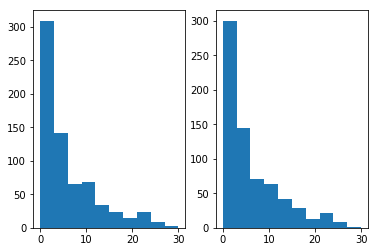

In [92]:
%matplotlib inline
plt.subplot(1,2,1)
plt.hist(y)
plt.subplot(1,2,2)
plt.hist(y2)

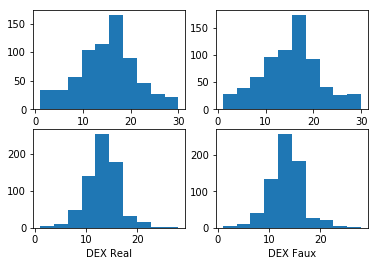

In [114]:
numrows = 2#len(colz)

for thiscol in enumerate(colz[0:2]):    
    plt.subplot(numrows,2,2*thiscol[0]+1)
    plt.hist(df[thiscol[1]])
    plt.xlabel(thiscol[1]+' Real')
    plt.subplot(numrows,2,2*thiscol[0]+2)
    plt.hist(faux_df[thiscol[1]])
    plt.xlabel(thiscol[1]+' Faux')
    

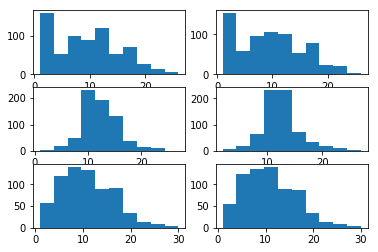

In [110]:
for thiscol in enumerate(colz[3:]):    
    plt.subplot(numrows,2,2*thiscol[0]+1)
    plt.hist(df[thiscol[1]])
    plt.subplot(numrows,2,2*thiscol[0]+2)
    plt.hist(faux_df[thiscol[1]])

KeyError: IndexError('indices are out-of-bounds',)

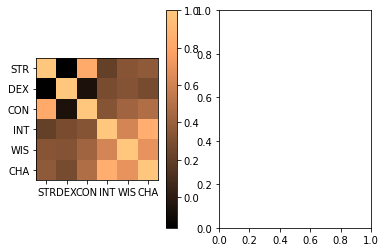

In [117]:
#colz = ['CR','HP','AC','STR','DEX','INT','CON','WIS','CHA']
colz = ['STR','DEX','CON','INT','WIS','CHA']
X3 = df.iloc[:,[xx in colz for xx in df.columns]]
plt.subplot(1,2,1)
f1=plt.imshow(np.corrcoef(X3.transpose()),cmap='copper')
f1.axes.set_xticklabels(colz)
f1.axes.set_xticks(range(len(colz)))
f1.axes.set_yticklabels(colz)
f1.axes.set_yticks(range(len(colz)))
plt.colorbar()
plt.subplot(1,2,2)
X4 = faux_df.loc[:,[xx in colz for xx in df.columns]]
f2=plt.imshow(np.corrcoef(X4.transpose()),cmap='copper')
f2.axes.set_xticklabels(colz)
f2.axes.set_xticks(range(len(colz)))
f2.axes.set_yticklabels(colz)
f2.axes.set_yticks(range(len(colz)))

plt.colorbar()

(array([   6.,   10.,   48.,  139.,  255.,  178.,   32.,   16.,    3.,    3.]),
 array([  1. ,   3.7,   6.4,   9.1,  11.8,  14.5,  17.2,  19.9,  22.6,
         25.3,  28. ]),
 <a list of 10 Patch objects>)

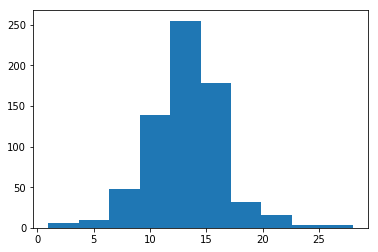

In [121]:
plt.hist(df.DEX)

(array([  34.,   34.,   56.,  103.,  114.,  165.,   89.,   46.,   27.,   22.]),
 array([  1. ,   3.9,   6.8,   9.7,  12.6,  15.5,  18.4,  21.3,  24.2,
         27.1,  30. ]),
 <a list of 10 Patch objects>)

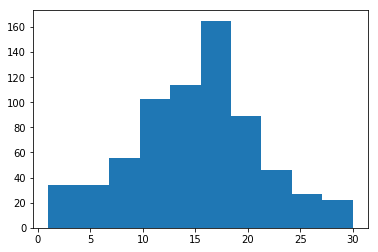

In [122]:
plt.hist(df.STR)

(array([   1.,   11.,   99.,  145.,  214.,  100.,   58.,   31.,   23.,    8.]),
 array([  3. ,   5.7,   8.4,  11.1,  13.8,  16.5,  19.2,  21.9,  24.6,
         27.3,  30. ]),
 <a list of 10 Patch objects>)

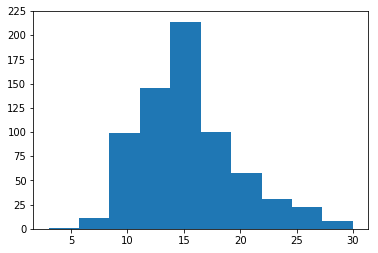

In [123]:
plt.hist(df.CON)

(array([ 158.,   52.,  100.,   88.,  121.,   53.,   71.,   28.,   14.,    5.]),
 array([  1. ,   3.5,   6. ,   8.5,  11. ,  13.5,  16. ,  18.5,  21. ,
         23.5,  26. ]),
 <a list of 10 Patch objects>)

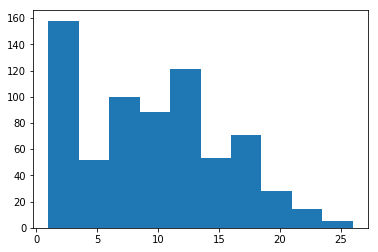

In [124]:
plt.hist(df.INT)


(array([   5.,   18.,   51.,  230.,  191.,  131.,   37.,   15.,   10.,    2.]),
 array([  1. ,   3.6,   6.2,   8.8,  11.4,  14. ,  16.6,  19.2,  21.8,
         24.4,  27. ]),
 <a list of 10 Patch objects>)

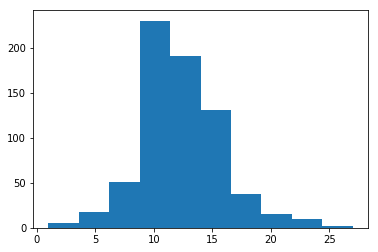

In [125]:
plt.hist(df.WIS)

(array([  58.,  120.,  140.,  132.,   89.,   91.,   35.,   13.,    9.,    3.]),
 array([  1. ,   3.9,   6.8,   9.7,  12.6,  15.5,  18.4,  21.3,  24.2,
         27.1,  30. ]),
 <a list of 10 Patch objects>)

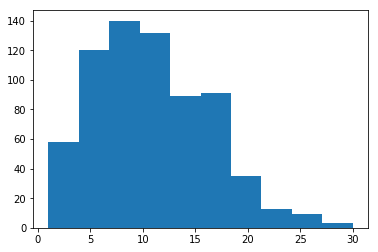

In [126]:
plt.hist(df.CHA)